<ipython-input-5-e99e169c8c49>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tmp = user_balance.groupby(['date'])['value', 'rate'].sum()


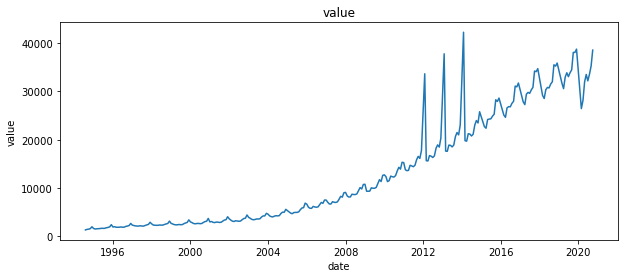

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
user_balance = pd.read_csv('C:/Users/lenovo/Desktop/test2.csv')
df_tmp = user_balance.groupby(['date'])['value', 'rate'].sum()
df_tmp.reset_index(inplace=True)
df_tmp.index = df_tmp['date']
df_tmp['date'] = pd.to_datetime(df_tmp['date'], format='%Y%m%d')
total_purchase_amt = plt.figure(figsize=(10, 4))
ax = total_purchase_amt.add_subplot(111)
ax.set(title='value',
       ylabel='value', xlabel='date',)
plt.plot(df_tmp['date'], df_tmp['value'])
plt.show()

从上图中可以看出，从2012~2014，该指数经历了一个较大的波动过程，从2014开始，趋向于稳定的震荡（均值近似为常数）。ARIMA 模型是通过寻找历史数据之间的自相关性，来预测未来（假设未来将重复历史的走势），要求序列必须是平稳的。因此我们取2014~2016的数据作为训练集，将2017~2020的数据作为测试集。

In [13]:
import os
os.getcwd()

'C:\\Users\\lenovo'

In [16]:
import os
os.getcwd()
import pandas as pd

def generate_purchase_seq():
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')
    user_balance = pd.read_csv('C:/Users/lenovo/Desktop/test2.csv', parse_dates=['date'],
                               index_col='date', date_parser=dateparse)

    df = user_balance.groupby(['date'])['value'].sum()
    purchase_seq = pd.Series(df, name='value2')

    purchase_seq_train = purchase_seq['2014-01-01':'2016-12-31']
    purchase_seq_test = purchase_seq['2017-01-01':'2020-12-07']

    purchase_seq_train.to_csv('C:/Users/lenovo/Desktop/purchase_seq_train.csv')
    purchase_seq_test.to_csv('C:/Users/lenovo/Desktop/purchase_seq_test.csv')
generate_purchase_seq()

<ipython-input-16-d5fc67957406>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')


查看一下训练集 purchase_seq_train.csv 的差分效果，并对每一次差分结果做 ADF 检验：

<ipython-input-19-9b5c17f611df>:32: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')


timeseries_adf :  (3.7713031630776173, 1.0, 11, 288, {'1%': -3.453261605529366, '5%': -2.87162848654246, '10%': -2.5721455328896603}, 5107.221517707736)
timeseries_diff1_adf :  (-7.612836250772181, 2.2315188182374757e-11, 11, 288, {'1%': -3.453261605529366, '5%': -2.87162848654246, '10%': -2.5721455328896603}, 5118.784900915126)
timeseries_diff2_adf :  (-11.183295655492149, 2.4702142715144855e-20, 14, 285, {'1%': -3.4535050041524245, '5%': -2.8717352599720294, '10%': -2.5722024776854417}, 5139.625513965207)


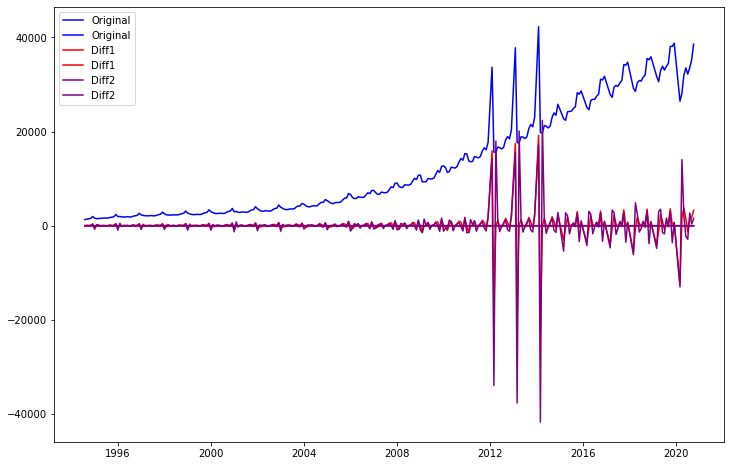

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF


def diff(timeseries):
    timeseries_diff1 = timeseries.diff(1)
    timeseries_diff2 = timeseries_diff1.diff(1)

    timeseries_diff1 = timeseries_diff1.fillna(0)
    timeseries_diff2 = timeseries_diff2.fillna(0)

    timeseries_adf = ADF(timeseries['value'].tolist())
    timeseries_diff1_adf = ADF(timeseries_diff1['value'].tolist())
    timeseries_diff2_adf = ADF(timeseries_diff2['value'].tolist())

    print('timeseries_adf : ', timeseries_adf)
    print('timeseries_diff1_adf : ', timeseries_diff1_adf)
    print('timeseries_diff2_adf : ', timeseries_diff2_adf)

    plt.figure(figsize=(12, 8))
    plt.plot(timeseries, label='Original', color='blue')
    plt.plot(timeseries_diff1, label='Diff1', color='red')
    plt.plot(timeseries_diff2, label='Diff2', color='purple')
    plt.legend(loc='best')
    plt.show()


dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')
purchase_seq_train = pd.read_csv('C:/Users/lenovo/Desktop/test2.csv', parse_dates=['date'],
                                 index_col='date', date_parser=dateparse)
diff(purchase_seq_train)

从结果来看，要想使得序列变得平稳，需要进行一阶差分。我们对序列进行一阶差分，并查看差分后序列的 ACF、PACF：

<ipython-input-21-47429bb4d348>:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


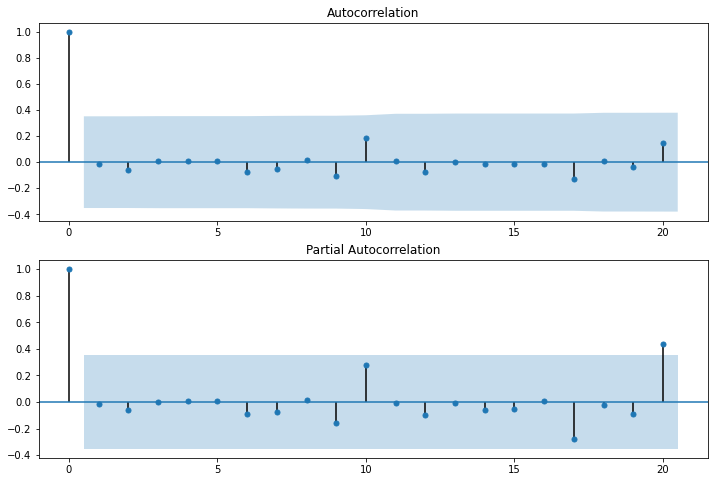

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF


def autocorrelation(timeseries, lags):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(timeseries, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
    plt.show()


dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_train = pd.read_csv('C:/Users/lenovo/Desktop/purchase_seq_train.csv', parse_dates=['date'],
                                 index_col='date', date_parser=dateparse)

purchase_seq_train_diff = purchase_seq_train.diff(1)
purchase_seq_train_diff = purchase_seq_train_diff.fillna(0)

autocorrelation(purchase_seq_train_diff, 20)